# SOL-PMT meta
Create meta for SOL-PMT from the original SOL-O.9HQ dataset. SOL-PMT: subset of SOL-O.9HQ, comprising 5 types of periodic modulation techniques.
1. Check meta information of the original SOL-O.9HQ dataset
2. Collect PMTs and generate meta, including label and data split
3. Content investigation of SOL-PMT: playing technique histograms, pitch range and number of mutes

In [1]:
import pandas as pd
import os
from fnmatch import fnmatch
import collections as cl
import shutil
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# follow paper class order
class_map = {'vibrato': 0,
             'trill': 1,
             'tremolo': 2,
             'bisbigliando': 3,
             'flatterzunge': 4
             }
             
# class abbrevation map
class_abbrv = {'vibrato': 'vib',
               'trill': 'trill',
               'tremolo': 'trem',
               'bisbigliando': 'bisb',
               'flatterzunge': 'flatt'
              }

## SOL-0.9HQ meta

In [3]:
# find all .wav files in subdirectories
data_dir = '../datasets/SOL_0.9_HQ/'
target = "*.wav"
wav_files = []   # create a list for the files
for path, subdirs, files in os.walk(data_dir):
    for name in files:
        if fnmatch(name, target):
            wav_files.append(os.path.join(path, name))  
print('Number of audio files:', format(len(wav_files)))

for k in range(len(wav_files)):
    wav_files[k] = wav_files[k].replace(data_dir, '')

Number of audio files: 25466


In [4]:
# find technique names with "non", e.g "nonvib" = non-vibrato
tech_with_non = []
for wav in wav_files:
    if 'non' in wav:
        tech_with_non.append(os.path.normpath(wav).split(os.sep)[-2])
len(tech_with_non)

1894

In [5]:
# create a DataFrame to save dataset meta information
meta = pd.DataFrame(columns=['instrument family', 'instrument', 
        'technique original', 'modulation technique', 'file_name'])

meta['instrument family'] = [os.path.normpath(wav).split(os.sep)[0] for wav in wav_files]
meta['instrument'] = [os.path.normpath(wav).split(os.sep)[1] for wav in wav_files]
meta['technique original'] = [os.path.normpath(wav).split(os.sep)[2] for wav in wav_files]
meta['modulation technique'] = ['other'] * len(meta)
meta['file_name'] = [os.path.normpath(wav).split(os.sep)[-1] for wav in wav_files]
len(meta['technique original'].unique())

143

In [6]:
# get modulation technique based on file name

for k in range(len(meta)):
    for class_name in class_abbrv:
        if class_abbrv[class_name] in meta['file_name'][k]:
            if 'nonvib' in meta['file_name'][k]:
                meta['modulation technique'][k] = 'other'
            else:
                meta['modulation technique'][k] = class_name

## SOL-PMT

In [7]:
meta_PMT = meta.loc[meta["modulation technique"] != 'other']
meta_PMT = meta_PMT.reset_index(drop=True)
meta_PMT

,instrument family,instrument,technique original,modulation technique,file_name
0,Trombones,Tenor-Trombone-wah,flatterzunge-open,flatterzunge,TTbn+W-flatt-open-F#2-mf.wav
1,Trombones,Tenor-Trombone-wah,flatterzunge-open,flatterzunge,TTbn+W-flatt-open-A#3-mf.wav
2,Trombones,Tenor-Trombone-wah,flatterzunge-open,flatterzunge,TTbn+W-flatt-open-C4-mf.wav
3,Trombones,Tenor-Trombone-wah,flatterzunge-open,flatterzunge,TTbn+W-flatt-open-E3-mf.wav
4,Trombones,Tenor-Trombone-wah,flatterzunge-open,flatterzunge,TTbn+W-flatt-open-G#4-mf.wav
...,...,...,...,...,...
5559,Strings,Viola-sordina,tremolo,tremolo,Va+S-trem-A#4-mf-2c.wav
5560,Strings,Viola-sordina,tremolo,tremolo,Va+S-trem-G4-mf-3c.wav
5561,Strings,Viola-sordina,tremolo,tremolo,Va+S-trem-C#3-mf-4c.wav
5562,Strings,Viola-sordina,tremolo,tremolo,Va+S-trem-F4-mf-2c.wav


In [8]:
cl.Counter(meta_PMT['modulation technique'])

Counter({'flatterzunge': 1523,
         'vibrato': 190,
         'trill': 1035,
         'tremolo': 2530,
         'bisbigliando': 286})

## create data split according to meta

In [9]:
df = meta_PMT
df_split = pd.DataFrame(columns=['instrument family', 'instrument', 
        'technique original', 'modulation technique', 'file_name', 'subset', 'label'])
df_shuffled = df.sample(frac=1, random_state=0)
df_shuffled

,instrument family,instrument,technique original,modulation technique,file_name
871,Trumpets,Trumpet-C-wah,flatterzunge-open,flatterzunge,TpC+W-flatt-open-G5-mf.wav
2200,Tubas,Bass-Tuba,flatterzunge,flatterzunge,BBTb-flatt-C#2-pp.wav
1427,Horns,Horn,flatterzunge,flatterzunge,Hn-flatt-B3-pp.wav
5159,Strings,Viola,tremolo,tremolo,Va-trem-A#4-ff-3c.wav
1185,PluckedStrings,Harp,bisbigliando-with-stick,bisbigliando,Hp-bisb+stick-A#5-mf.wav
...,...,...,...,...,...
4931,Strings,Viola,artificial-harmonic-tremolo,tremolo,Va-art-harm-trem-A#5-mf-4c.wav
3264,Strings,Violin-sordina,tremolo,tremolo,Vn+S-trem-A4-pp-2c.wav
1653,Horns,Horn,flatterzunge-to-ordinario,flatterzunge,Hn-flatt_ord-F3-f.wav
2607,Strings,Violin,trill-minor-second-up,trill,Vn-trill-min2-E5-mf-1c.wav


In [10]:
for tech in class_map:
    df_tech = df_shuffled[df_shuffled['modulation technique'] == tech] # shuffle dataset before spliting
    # split each class into training-validation-test by ratio 6:2:2
    for inst in df_tech['instrument'].unique():
        df_inst_class = df_tech[df_tech['instrument']==inst].reset_index(drop=True)
        df_inst_class['subset'] = ['training'] * int(len(df_inst_class) * 0.6) + \
                               ['validation'] * int(len(df_inst_class) * 0.2) + \
                               ['test'] * (len(df_inst_class) - int(len(df_inst_class) * 0.6) - int(len(df_inst_class) * 0.2))
        df_inst_class['label'] = [class_map[tech]] * len(df_inst_class)
        df_split = df_split.append(df_inst_class, ignore_index=True)

In [11]:
cl.Counter(df_split['modulation technique'])

Counter({'vibrato': 190,
         'trill': 1035,
         'tremolo': 2530,
         'bisbigliando': 286,
         'flatterzunge': 1523})

In [12]:
meta_PMT = df_split
meta_PMT

,instrument family,instrument,technique original,modulation technique,file_name,subset,label
0,Bassoons,Bassoon,vibrato,vibrato,Bn-vib-D2-mf.wav,training,0
1,Bassoons,Bassoon,vibrato,vibrato,Bn-vib-A#3-mf.wav,training,0
2,Bassoons,Bassoon,vibrato,vibrato,Bn-vib-D#5-mf.wav,training,0
3,Bassoons,Bassoon,vibrato,vibrato,Bn-vib-E2-mf.wav,training,0
4,Bassoons,Bassoon,vibrato,vibrato,Bn-vib-F#3-mf.wav,training,0
...,...,...,...,...,...,...,...
5559,Bassoons,Bassoon,flatterzunge,flatterzunge,Bn-flatt-A4-mf.wav,test,4
5560,Bassoons,Bassoon,flatterzunge,flatterzunge,Bn-flatt-G#3-mf.wav,test,4
5561,Bassoons,Bassoon,flatterzunge,flatterzunge,Bn-flatt-C5-mf.wav,test,4
5562,Bassoons,Bassoon,flatterzunge,flatterzunge,Bn-flatt-G2-mf.wav,test,4


### pitch range of SOL-PMT

In [13]:
keys = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
pitch = []

for wav in df['file_name']:
    if set(keys).intersection(wav.split('-')[-2]):
        pitch.append(wav.split('-')[-2])
    elif set(keys).intersection(wav.split('-')[-3]):
        pitch.append(wav.split('-')[-3])

len(set(pitch))

83

In [14]:
freq = [librosa.note_to_hz(item) for item in pitch]
print(librosa.hz_to_note(min(freq)), min(freq))
print(librosa.hz_to_note(max(freq)), max(freq))

C♯1 34.64782887210901
B7 3951.066410048992


### histogram over instruments

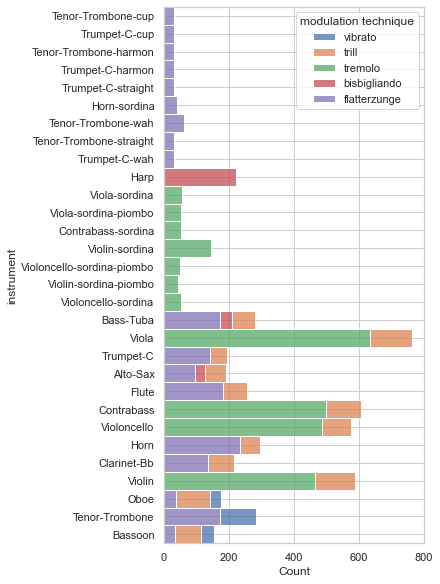

In [15]:
plt.rcParams['figure.constrained_layout.use'] = True
sns.set_theme(context='notebook', style='whitegrid')
plt.figure(figsize=(6,8))
ax = sns.histplot(data=meta_PMT, y="instrument", hue="modulation technique", multiple="stack")
plt.ylim(-.5, 29.5)
# plt.savefig('results/playtech_histogram_instruments.pdf')
plt.savefig('results/playtech_histogram_instruments.png')

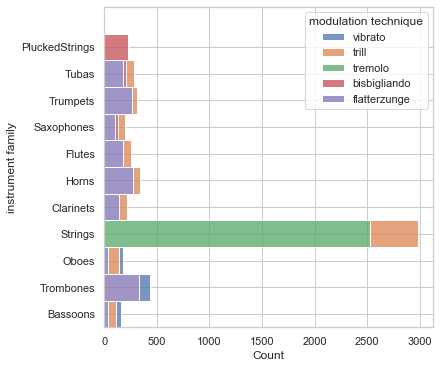

In [16]:
plt.rcParams['figure.constrained_layout.use'] = True
sns.set_theme(context='notebook', style='whitegrid')
plt.figure(figsize=(6,5))
ax = sns.histplot(data=meta_PMT, y="instrument family", hue="modulation technique", multiple="stack")
plt.ylim(-.5, 11.5)
# plt.savefig('results/playtech_histogram_instrufamily.pdf')
plt.savefig('results/playtech_histogram_instrufamily.png')

## check mute 

In [17]:
# find all .wav files
target = "*.wav"
wav_files = [] 
for path, subdirs, files in os.walk(data_dir):
    for name in files:
        if fnmatch(name, target):
            wav_files.append(os.path.join(path, name))   
print('Number of audio files:', format(len(wav_files)))

for k in range(len(wav_files)):
    wav_files[k] = wav_files[k].replace(data_dir, '')

Number of audio files: 25466


In [18]:
# "sordina" means "mute" in Italian
mute = [os.path.normpath(file).split(os.sep)[1] if 'sordina' in file else None for file in wav_files]
cl.Counter(mute)

Counter({None: 23296,
         'Oboe-sordina': 36,
         'Horn-sordina': 87,
         'Violin-sordina': 574,
         'Violoncello-sordina-piombo': 143,
         'Violoncello-sordina': 351,
         'Contrabass-sordina': 351,
         'Violin-sordina-piombo': 123,
         'Viola-sordina-piombo': 125,
         'Viola-sordina': 380})

## create a separate directory for SOL-PMT

In [3]:
modu_dir = '../datasets/SOL-0.9HQ-PMT/'
modu_wav = [os.path.join(row['instrument family'], row['instrument'], row['technique original'],
            row['file_name']) for idx, row in meta_PMT.iterrows()]

In [24]:
wav_dir = set([os.path.split(wav)[0] for wav in modu_wav])
for wav in wav_dir:
    os.makedirs(modu_dir + wav) 

for wav in modu_wav:
    shutil.copy(data_dir + wav, modu_dir + wav)

In [22]:
# check number of modulation technique audio files
target = "*.wav"
wav_files = []   
for path, subdirs, files in os.walk(modu_dir):
    for name in files:
        if fnmatch(name, target):
            wav_files.append(os.path.join(path, name))   
print('Number of audio files:', format(len(wav_files)))

Number of audio files: 5564


In [14]:
# save meta_PMT
# meta_PMT = meta_PMT.sample(frac=1, random_state=0)
meta_PMT.to_csv(modu_dir + 'SOL-0.9HQ-PMT_meta.csv', index=False)
meta_PMT

,instrument family,instrument,technique original,modulation technique,file_name,subset,label
0,Bassoons,Bassoon,vibrato,vibrato,Bn-vib-D2-mf.wav,training,0
1,Bassoons,Bassoon,vibrato,vibrato,Bn-vib-A#3-mf.wav,training,0
2,Bassoons,Bassoon,vibrato,vibrato,Bn-vib-D#5-mf.wav,training,0
3,Bassoons,Bassoon,vibrato,vibrato,Bn-vib-E2-mf.wav,training,0
4,Bassoons,Bassoon,vibrato,vibrato,Bn-vib-F#3-mf.wav,training,0
...,...,...,...,...,...,...,...
5559,Bassoons,Bassoon,flatterzunge,flatterzunge,Bn-flatt-A4-mf.wav,test,4
5560,Bassoons,Bassoon,flatterzunge,flatterzunge,Bn-flatt-G#3-mf.wav,test,4
5561,Bassoons,Bassoon,flatterzunge,flatterzunge,Bn-flatt-C5-mf.wav,test,4
5562,Bassoons,Bassoon,flatterzunge,flatterzunge,Bn-flatt-G2-mf.wav,test,4


In [15]:
print(len(meta_PMT[meta_PMT['subset'] == 'training']), len(meta_PMT[meta_PMT['subset'] == 'validation']),
len(meta_PMT[meta_PMT['subset'] == 'test']))

3320 1098 1146


In [4]:
# save class_abbrevation
with open(modu_dir + 'class_abbrevation.json', 'w') as f:
    json.dump(class_abbrv, f)